# Training

In [35]:
# regular expressions
import re

# files
import os

# images
import cv2 as cv

# data visualizations
import matplotlib.pyplot as plt

# numpy
import numpy as np

# sklearn
from sklearn.model_selection import train_test_split

# tensorflow
from tensorflow.random import set_seed
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Dense, Flatten, Reshape, Input, InputLayer
from keras.models import Model
from tensorflow.keras.models import load_model

In [36]:
# utility.py functions
from utility import data_loader, predict_image

In [37]:
# Set seed for all future operations with tensorflow
set_seed(17)

## Data loader

In [38]:
X_train = data_loader('../Data/Prepared/Train/OK', scale=True)
X_noisy = data_loader('../Data/Prepared/Train/noisyOK', scale=True)
X_anomaly = data_loader('../Data/Prepared/Train/NOK', scale=False)

## Train e validation set

In [39]:
X_train, X__train_val = train_test_split(np.expand_dims(np.array(X_train), -1), test_size=0.2, random_state=17)
X_noisy, X__noisy_val = train_test_split(np.expand_dims(np.array(X_noisy), -1), test_size=0.2, random_state=17)

# Autoencoder

In [40]:
img_shape = X_train.shape[1:]
input_img = Input(img_shape)

#encoded = Dense(1, activation='relu')
encoded = Flatten()(input_img)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dense(64, activation='relu')(encoded)

decoded = Dense(128, activation='relu')(encoded)
decoded = Dense(np.prod(img_shape))(decoded)
decoded = Reshape((img_shape))(decoded)

In [41]:
autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adamax', loss='mse')

In [42]:
autoencoder.summary()

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 65536)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 128)               8388736   
_________________________________________________________________
dense_13 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_14 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_15 (Dense)             (None, 65536)             8454144   
_________________________________________________________________
reshape_3 (Reshape)          (None, 256, 256, 1)      

In [43]:
#add early stopping
custom_early_stopping = EarlyStopping(monitor='val_loss', patience=20, min_delta=0.0001, mode='min')

hist=autoencoder.fit(X_noisy, X_train, epochs=300, batch_size=16, shuffle=True,
                     validation_data=(X__noisy_val, X__train_val), callbacks=[custom_early_stopping])

Epoch 1/300
149/149 [==============================] - 17s 116ms/step - loss: 0.0540 - val_loss: 0.0242
Epoch 2/300
149/149 [==============================] - 17s 116ms/step - loss: 0.0183 - val_loss: 0.0145
Epoch 3/300
149/149 [==============================] - 17s 116ms/step - loss: 0.0134 - val_loss: 0.0121
Epoch 4/300
149/149 [==============================] - 17s 115ms/step - loss: 0.0118 - val_loss: 0.0116
Epoch 5/300
149/149 [==============================] - 18s 119ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 6/300
149/149 [==============================] - 16s 111ms/step - loss: 0.0107 - val_loss: 0.0102
Epoch 7/300
149/149 [==============================] - 20s 132ms/step - loss: 0.0102 - val_loss: 0.0097
Epoch 8/300
149/149 [==============================] - 21s 139ms/step - loss: 0.0098 - val_loss: 0.0102
Epoch 9/300
149/149 [==============================] - 22s 151ms/step - loss: 0.0092 - val_loss: 0.0087
Epoch 10/300
149/149 [==============================] - 17s 112m

In [64]:
# Function to summarize history for loss
def plot_hist(hist, title):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("LOSS " + title)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

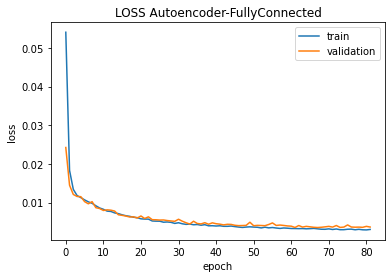

In [65]:
plot_hist(hist, 'Autoencoder-FullyConnected')

### Sample with spot artificially producted

Text(0.5, 1.0, 'Reconstructed')

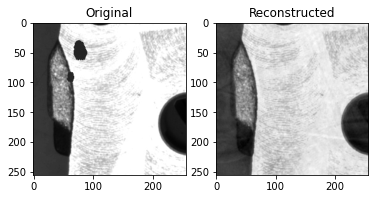

In [63]:
#plt.figure(figsize=(20,20))

plt.subplot(1, 2, 1)
plt.imshow(np.squeeze(X_noisy[5],-1), cmap='gray')
plt.title('Original')

plt.subplot(1, 2, 2)
test_artificial = autoencoder.predict(np.expand_dims(X_noisy[5],0))
plt.imshow(np.squeeze(test_artificial[0], -1), cmap='gray')
plt.title('Reconstructed')

### Saving model 

In [53]:
autoencoder.save("../Models/autoencoderFC")

INFO:tensorflow:Assets written to: ../Models/autoencoderFC\assets


# Prediction of anomalies
Anomalies are detected and located by analysis the differences between the orignal image and the one reconstructed by the autoencoder. The original image is first preprocessed, divided in slices and every slice is processed by the autoencoder. The processed slices are then concateneted to reconstruct the full image.
The result of the difference between the 2 images is processed by the opencv function threshold, so the pixel that are different in the 2 images will become white and all the rest will be black. From that mask is possible to extract the bounding boxes of the white pixels, to show where the anomalies are. 

Images are predicted as defective if there is at least one anomaly detected. The reconstruction score (SSIM between the original image and the reconstructed one) is given to understand if the autoencoder was able to effectively reconstruct the image.

In [54]:
autoencoder = load_model("../Models/autoencoderFC")

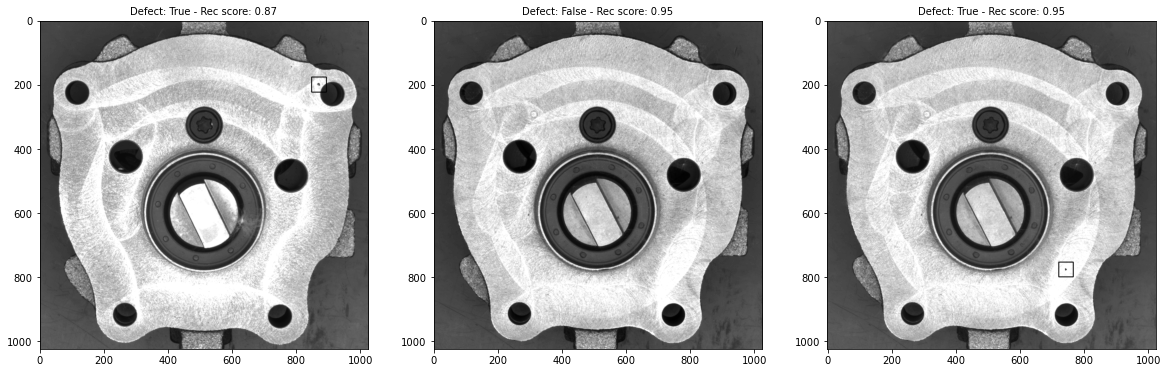

In [55]:
plt.figure(figsize=(20, 20))
i=1
for img in X_anomaly:
    anom, img_anom, sim_score = predict_image(img, autoencoder)
    plt.subplot(1, 3, i)
    plt.title('Defect: ' + str(anom) + ' - Rec score: ' + str(round(sim_score, 2)), fontsize=10)
    plt.imshow(img_anom, cmap='gray')
    i=i+1